In [37]:
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_circles
import warnings
warnings.filterwarnings('ignore')

import torch 
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset 
import torch.nn.functional as F
import torch.nn as nn

from symreg import evaluate_composition, evaluate_tree, SymReg
np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def contains_pattern(sequence, pattern):
    pattern_str = ''.join(map(str, pattern))
    sequence_str = ''.join(map(str, sequence))
    return pattern_str in sequence_str

In [3]:
all_nums = []
for i in range(16):
    all_nums.append(list(map(int, np.binary_repr(i, 4))))
all_nums = np.array(all_nums)
y1 = np.array([contains_pattern(i, [1, 0, 1]) for i in all_nums])
y2 = []
for i in all_nums:
    cnt = 0
    for j in range(0, 2):
        if contains_pattern(i[j:j+3], [1, 1, 1]):
            cnt+=1
    y2.append(cnt)
y2 = np.array(y2)


In [4]:
rs = np.random.RandomState(42)
y1_new = list(range(len(all_nums)))
while y1[y1_new].mean() != 0.5:
    if y1[y1_new].mean()>0.5:
        to_add = [i for i in range(len(all_nums)) if y1[i] == 0]
    else:
        to_add = [i for i in range(len(all_nums)) if y1[i] == 1]
    to_add = rs.choice(to_add)
    y1_new.append(to_add)
y1 = y1[y1_new]
y1.mean(), len(y1)

(np.float64(0.5), 24)

In [5]:
train_dataset = all_nums[y1_new], y1
test_dataset = train_dataset

In [6]:
from collections import Counter
rs = np.random.RandomState(42)
y2_new = list(range(len(all_nums)))
cnt0 = (y2[y2_new]==0).sum()
cnt1 = (y2[y2_new]==1).sum()
cnt2 = (y2[y2_new]==2).sum()

while (cnt0 != cnt1) or (cnt1 != cnt2):
    to_add = np.argsort([cnt0, cnt1, cnt2])[0]
    to_add = [i for i in range(len(all_nums)) if y2[i] == to_add]
    to_add = rs.choice(to_add)
    y2_new.append(to_add)
    cnt0 = (y2[y2_new]==0).sum()
    cnt1 = (y2[y2_new]==1).sum()
    cnt2 = (y2[y2_new]==2).sum()


y2 = y2[y2_new]
Counter(y2), len(y2)

(Counter({np.int64(0): 13, np.int64(1): 13, np.int64(2): 13}), 39)

In [7]:
train_dataset2 = all_nums[y2_new], y2
test_dataset2 = train_dataset2

In [8]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=10.0)
model.fit(train_dataset[0], train_dataset[1])
print (np.equal(model.predict(test_dataset[0]), test_dataset[1]).mean())

0.7916666666666666


In [9]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_dataset2[0], train_dataset2[1])
print (((model.predict(test_dataset2[0]) - test_dataset2[1])**2).mean())

0.1352328030798286


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
D = 4

class SimpleCNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv = nn.Conv1d(
            1, 1, kernel_size=3)  # 4 фильтра, каждый ищет свой шаблон
        self.pool = lambda x: x.max(1).values.max(1).values  #nn.AdaptiveMaxPool2d(1)  # "обобщает" по всему пространству
        self.fc = nn.Linear(1, 1)  # логрегрессия по 4 признакам

    def forward(self, x):
        x = x.view(-1, 1, D).float()
        x = self.conv(x)  # [B, 2, H-2, W-2]
        
        x = self.pool(x)  # [B, 2, 1, 1]

        x = x.view(x.size(0), -1)  # [B, 2]
        x = self.fc(x)  # [B, 1]
        return x  # [B, 1]

epochs = 1000
model = SimpleCNN()
opt = torch.optim.Adam(model.parameters(), lr=1e-1)
tq = tqdm.tqdm(range(1000))
for e in tq:
    opt.zero_grad()
    out = model(torch.tensor(train_dataset[0])).view(-1)
    
    loss = torch.nn.BCEWithLogitsLoss()(out, torch.tensor(train_dataset[1]).float())
    loss.backward()
    opt.step()
    tq.set_description(str(loss.item()))

0.001234901137650013:  14%|█▍        | 143/1000 [00:35<03:33,  4.00it/s] 


KeyboardInterrupt: 

In [53]:
out = model( torch.tensor(test_dataset[0]))>0.0
torch.eq(out.view(-1), torch.tensor(test_dataset[1]).view(-1)).float().mean()


tensor(0.7083)

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
D = 4

class SimpleCNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv = nn.Conv1d(
            1, 1, kernel_size=3)  # 4 фильтра, каждый ищет свой шаблон
        self.pool = lambda x: torch.nn.functional.leaky_relu(x).sum(1).sum(1)  #nn.AdaptiveMaxPool2d(1)  # "обобщает" по всему пространству
        self.fc = nn.Linear(1, 1)  # логрегрессия по 4 признакам

    def forward(self, x):
        x = x.view(-1, 1, D).float()
        x = self.conv(x)  # [B, 2, H-2, W-2]
        
        x = self.pool(x)  # [B, 2, 1, 1]

        x = x.view(x.size(0), -1)  # [B, 2]
        x = self.fc(x)  # [B, 1]
        return x  # [B, 1]

epochs = 1000
model = SimpleCNN()
opt = torch.optim.Adam(model.parameters(), lr=1e-1)
tq = tqdm.tqdm(range(1000))
for e in tq:
    opt.zero_grad()
    out = model(torch.tensor(train_dataset2[0])).view(-1)
    
    loss = ((out - torch.tensor(train_dataset2[1]))**2).mean()
    loss.backward()
    opt.step()
    tq.set_description(str(loss.item()))

6.163609214127064e-05:  73%|███████▎  | 732/1000 [00:02<00:00, 315.00it/s] 


KeyboardInterrupt: 

Process ForkPoolWorker-1013:
Process ForkPoolWorker-1014:
Process ForkPoolWorker-1012:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  F

In [10]:
out = model(torch.tensor(train_dataset2[0])).view(-1)
((out - torch.tensor(train_dataset2[1]))**2).mean()


TypeError: 'LinearRegression' object is not callable

In [11]:
X_all = np.vstack([train_dataset[0], train_dataset2[0]])
y_all = np.hstack([train_dataset[1], train_dataset2[1]])
X_all.shape, y_all.shape

((63, 4), (63,))

In [12]:
def varible_node_in_tree(node):
    result = set()
    buf = [node]
    while len(buf) > 0:
        new_node = buf.pop()
        if new_node.is_leaf():
            result.add(new_node.value)
        else:
            buf.extend(new_node.children)
    return result

In [28]:
from scipy.optimize import minimize
from symreg import evaluate_composition, DEFAULT_OPERATIONS

import zlib


def compress_score(expression_str: str):
    compressed = zlib.compress(expression_str.encode('utf-8'))
    return len(compressed)


def compress_hiddens(composition):
    return compress_score(';'.join([
        h.polish(DEFAULT_OPERATIONS) for h in composition.children_h]))


def acc_loss_fn_min(x, y, ind, variables, pool, OPERATIONS, COMP_SCORE=.001, SPARSE_SCORE=0.0, MAX_VARIABLES = 3):
    if COMP_SCORE:
        #compl = compress_score(';'.join([str(h) for h in ind.children_h
        #                             ]))
        compl = compress_hiddens(ind)

    else:
        compl = 0.0
    
    if MAX_VARIABLES > 0:
        sparse = ([
            len([c for c in varible_node_in_tree(h) if c.startswith('x')])
            for h in ind.children_h
        ])
        if max(sparse)>MAX_VARIABLES:
            return float('inf'), float('inf'), float('inf'), float('inf'), float('inf')
    if SPARSE_SCORE:
        sparse = max([
            len([c for c in varible_node_in_tree(h) if c.startswith('x')])
            for h in ind.children_h
        ])
    else:
        sparse = 0.0

    x_train1 = {f'x{i}': x[:24, i] for i in range(4)}
    y_train1 = y[:24]

    x_train2 = {f'x{i}': x[24:, i] for i in range(4)}
    y_train2 = y[24:]

    def min_func(x0, var_y):
        var_, y_ = var_y
        pool_ = {f'p{i}': x0[i] for i in range(len(x0))}

        y_pred = evaluate_composition(ind, var_, pool_, OPERATIONS) > 0
        errs = -np.equal(y_, y_pred).mean()
        return errs

    x_opt = minimize(min_func, list(pool.values()), [x_train1, y_train1])
    loss1 = min_func(x_opt.x, [x_train1, y_train1])
    """
    hidden1, out1 = evaluate_composition(ind, x_train1, {f'p{i}': x_opt.x[i] for i in range(len(x_opt.x))}, 
                                             OPERATIONS, 0, True)
    hidden1_array = []
    for h in hidden1.values():
        h = np.array(h)
        if len(h.shape) == 0:
            h = np.ones(24) * h
        hidden1_array.append(h)
    hidden1_array = np.array(hidden1_array).T
    mi = micd(hidden1_array, y_train1)
    """

    def min_func2(x0, var_y):
        var_, y_ = var_y
        pool_ = {f'p{i}': x0[i] for i in range(len(x0))}
        y_pred = evaluate_composition(ind, var_, pool_, OPERATIONS, g_id=1)
        y_pred = np.clip(y_pred, 0, 2)
        errs = ((y_ - y_pred)**2).mean() / 2
        return errs

    x_opt = minimize(min_func2, list(pool.values()), [x_train2, y_train2])

    loss2 = 0.0
    loss2 = min_func2(x_opt.x, [x_train2, y_train2])
    loss = (loss1 + loss2) / 2 + compl * COMP_SCORE + sparse * SPARSE_SCORE

    return loss, loss1, loss2, compl, sparse   #, mi

In [17]:
1

1

In [ ]:
import operator
reduced_operations = {
    'add': (operator.add, 2),
    'sub': (operator.sub, 2),
    'mult': (operator.mul, 2),
    'max': (np.maximum, 2)
}
import time
time_s = time.time()
run_num = 20
#gens = []
for r in range(run_num):
    symreg = SymReg(acc_loss_fn_min,
                    X_all,
                    y_all,
                    4,
                    2,
                    2,
                    2,
                    1000,
                    proc_num = 8,
                    operations=reduced_operations,
                    mutate_params=False,
                    max_depth=5)
    gens.append(symreg.fit(100, 10, 10, 10))

[Gen 0] Expr: 
h_0 = x2
h_1 = x1
g_0 = max(mult(p0, max(sub(mult(h1, p1), p1), h1)), max(sub(max(mult(h1, h1), max(h0, h0)), h1), max(mult(sub(p1, p1), max(h1, h0)), sub(add(h1, h0), sub(h1, h1)))))
g_1 = max(sub(mult(h1, add(h0, h1)), sub(mult(h1, p1), mult(h0, h1))), mult(mult(max(h0, h1), sub(h1, h0)), h1))
[Gen 0] Best errors: (np.float64(-0.24113675213675206), np.float64(-0.6666666666666666), np.float64(0.16239316239316245), 11.000000000000002, 0.0)
[Gen 0] Total time: 2.283897876739502
[Gen 10] Expr: 
h_0 = max(x3, p0)
h_1 = add(x0, x1)
g_0 = mult(mult(mult(max(mult(h0, h0), mult(h0, h0)), p0), add(sub(add(mult(h1, h0), p0), mult(h0, h0)), add(p0, h1))), p0)
g_1 = add(h0, add(mult(h0, p0), add(h1, p0)))
[Gen 10] Best errors: (np.float64(-0.34118016791468114), np.float64(-0.8333333333333334), np.float64(0.11697299750397107), 17.0, 0.0)
[Gen 10] Total time: 25.65399742126465
[Gen 20] Expr: 
h_0 = mult(x2, x0)
h_1 = mult(x1, x3)
g_0 = max(mult(p0, max(add(h1, h1), h1)), max(sub(max(

[Gen 70] Expr: 
h_0 = mult(x1, x2)
h_1 = mult(x3, max(mult(x1, p1), x0))
g_0 = sub(max(p0, h1), max(h0, p0))
g_1 = mult(h0, sub(mult(h1, max(add(add(p0, h1), h1), h1)), mult(sub(p1, h0), add(h1, max(h0, p0)))))
[Gen 70] Best errors: (np.float64(-0.4322051282051282), np.float64(-0.9166666666666665), np.float64(0.010256410256410263), 21.0, 0.0)
[Gen 70] Total time: 206.8057520389557
[Gen 80] Expr: 
h_0 = mult(x1, x2)
h_1 = mult(x3, max(mult(x1, p1), x0))
g_0 = sub(max(p0, h1), max(mult(h0, h1), p0))
g_1 = mult(h0, sub(mult(h1, max(add(add(p0, h1), h1), h1)), mult(sub(p1, h0), add(h1, max(h0, p0)))))
[Gen 80] Best errors: (np.float64(-0.4322051282051282), np.float64(-0.9166666666666665), np.float64(0.010256410256410263), 21.0, 0.0)
[Gen 80] Total time: 238.90065622329712
[Gen 90] Expr: 
h_0 = mult(x1, x2)
h_1 = mult(x3, max(mult(x1, p1), x0))
g_0 = sub(max(p0, h1), max(h0, p0))
g_1 = mult(h0, sub(mult(h1, max(add(add(p0, add(h0, p0)), h1), h1)), mult(sub(p1, h0), add(h1, max(h0, mult(h0, 

In [42]:
bad = 0
for g in gens[-20:]:
    if len({'x0', 'x3'} & varible_node_in_tree(g.children_h[0]))==2 or len({'x0', 'x3'} & varible_node_in_tree(g.children_h[1]))==2:
        bad+=1
bad

9

In [46]:
for g_id, g in enumerate(gens[-20:]):
    print (g_id, g.fitness.values)

0 (np.float64(-0.482), np.float64(-1.0), np.float64(5.533905632126493e-17), 18.0, 0.0)
1 (np.float64(-0.4322051282051282), np.float64(-0.9166666666666665), np.float64(0.010256410256410272), 21.0, 0.0)
2 (np.float64(-0.43287363379788596), np.float64(-0.9166666666666665), np.float64(0.012919399070894637), 19.0, 0.0)
3 (np.float64(-0.48), np.float64(-1.0), np.float64(5.266435960717949e-17), 20.0, 0.0)
4 (np.float64(-0.481), np.float64(-1.0), np.float64(5.075596234506717e-17), 19.0, 0.0)
5 (np.float64(-0.4237254901960784), np.float64(-0.9166666666666665), np.float64(0.0392156862745098), 15.0, 0.0)
6 (np.float64(-0.4195), np.float64(-0.875), np.float64(3.919701213340918e-17), 18.0, 0.0)
7 (np.float64(-0.483), np.float64(-1.0), np.float64(5.4856348365035943e-17), 17.0, 0.0)
8 (np.float64(-0.4393333333333333), np.float64(-0.9166666666666665), np.float64(4.463783359904153e-19), 19.0, 0.0)
9 (np.float64(-0.4352051282051282), np.float64(-0.9166666666666665), np.float64(0.010256410256410263), 18.

In [50]:
print(gens[-20:][-1])


h_0 = x3
h_1 = add(sub(x1, x3), x2)
g_0 = sub(mult(h0, sub(p0, h0)), mult(mult(h1, p1), max(h1, h1)))
g_1 = sub(max(p0, add(mult(p0, h0), sub(add(sub(h1, h1), add(h1, h1)), sub(h1, h0)))), sub(sub(h0, sub(mult(p1, h1), sub(h1, p1))), sub(sub(sub(h0, p1), add(h1, h1)), max(p1, h0))))


In [ ]:
import sympy as sp
import re

# Создаем переменные
symbols = ['x0', 'x1', 'x2', 'x3', 'p1']
locals_dict = {s: sp.Symbol(s) for s in symbols}

# Преобразование функции по имени
def apply_func(func, args):
    if func == 'add':
        return args[0] + args[1]
    elif func == 'sub':
        return args[0] - args[1]
    elif func == 'mult':
        return args[0] * args[1]
    elif func == 'div':
        return args[0] / args[1]
    elif func == 'max':
        return sp.Max(*args)
    elif func == 'min':
        return sp.Min(*args)
    else:
        raise ValueError(f"Unknown function: {func}")

# Парсер
def parse_expression(expr_str):
    # Удалим пробелы
    expr_str = expr_str.replace(' ', '')
    
    def parse(tokens):
        token = tokens.pop(0)
        if token in locals_dict:
            return locals_dict[token]
        elif re.match(r'^-?\d+(\.\d+)?$', token):
            return sp.sympify(token)
        elif token in {'add', 'sub', 'mult', 'div', 'max', 'min'}:
            assert tokens.pop(0) == '(', "Expected '('"
            args = []
            depth = 1
            current = ''
            while depth > 0:
                t = tokens.pop(0)
                if t == '(':
                    depth += 1
                    current += t
                elif t == ')':
                    depth -= 1
                    if depth == 0:
                        if current:
                            args.append(parse(tokenize(current)))
                        break
                    else:
                        current += t
                elif t == ',' and depth == 1:
                    args.append(parse(tokenize(current)))
                    current = ''
                else:
                    current += t
            return apply_func(token, args)
        else:
            return sp.Symbol(token)
    return parse(tokenize(expr_str))

# Токенизатор простого вида (можно заменить на парсер-парсер)
def tokenize(s):
    tokens = []
    i = 0
    while i < len(s):
        if s[i] in '(),':
            tokens.append(s[i])
            i += 1
        else:
            j = i
            while i < len(s) and s[i] not in '(),':
                i += 1
            tokens.append(s[j:i])
    return tokens



In [ ]:
# Пример
gen = gens[2]

expr = str(gen.children_h[0])
h0 = parse_expression(expr).simplify()

expr = str(gen.children_h[1])
h1 = parse_expression(expr).simplify()

expr = str(gen.children_g[0])
g0 = parse_expression(expr)


expr = str(gen.children_g[1])
g1 = parse_expression(expr)


print(h0)
print(h1)
g0 = (g0.subs({'h0': h0, 'h1': h1})).simplify()
g1 = (g1.subs({'h0': h0, 'h1': h1})).simplify()
print(g0)
print (g1)

NameError: name 'gens' is not defined

In [ ]:
from sympy import symbols, sin, log, Add, Max
Max.make_args(g1)

frozenset({p0*x1 - p0 - p1 + 3*x1 + 3*x2*(Max(p0, x0) - Max(p0, x2)) + 2*x2 + x3 + Max(p1, -x1 - x2*(Max(p0, x0) - Max(p0, x2)) - x2) - Max(p1, p0 + x1 + x2*(Max(p0, x0) - Max(p0, x2)) + x2)})

In [ ]:
from symreg import Node, Composition, DEFAULT_OPERATIONS
x1 = Node('x0')
x2 = Node('x1')
x3 = Node('x2')
x4 = Node('x3')
p0 = Node('p0')
p1 = Node('p1')
mx1 = Node('mult', [p0, x2])
mx2 = Node('mult', [p0, x3])

mx11 = Node('add', [mx1, x3])
mx22 = Node('add', [mx2, x4])

h1 = Node('add', [x1, mx11])
h2 = Node('add', [x2, mx22])
h1_ = Node('h0')
h2_ = Node('h1')
g0 = Node('max', [h1_, h2_])
comp = Composition([h1, h2], [Node('add', [g0, p0])])
print(comp)


h_0 = add(x0, add(mult(p0, x1), x2))
h_1 = add(x1, add(mult(p0, x2), x3))
g_0 = add(max(h0, h1), p0)


add(x0, add(mult(p0, x1), x2))


'AX,ACP,X,X'

In [ ]:

np.equal(np.round(evaluate_composition(comp, {f'x{i}':X_all[:24,i] for i in range(4)}, {'p0':  -1.0}, DEFAULT_OPERATIONS)) > 0, y_all[:24])


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [ ]:
compress_hiddens(comp)

21

In [ ]:
micd(hiddens, Y_all), compress_score(str(h1)+';'+str(h2)), np.corrcoef(hiddens.T)

In [ ]:
def simple_mi(h, y):
    mi = 0.0
    for _ in range(100):
        # Случайная проекция (например, гауссовская)
        P = np.random.randn(h.shape[1], 1)  # Проекция на 1 признак

        # Вычисление ковариации между x и проекцией y
        cov_matrix = np.cov(h @ P, y.reshape(-1, 1).T, rowvar=False)
        mi += cov_matrix[0, 1]**2
    return mi

In [ ]:
from mi import micd
conv_out = model.conv(train_dataset[0]).view(100, -1)
conv_out.shape
simple_mi(conv_out.detach().numpy(), train_dataset[1]), micd(conv_out.detach().numpy(), train_dataset[1])

RuntimeError: Given groups=1, weight of size [1, 1, 3], expected input[1, 100, 4] to have 1 channels, but got 100 channels instead

In [ ]:
from sklearn.metrics import mutual_info_score
from onetask_hid_pool import evaluate_tree


def discretize(vec, bins=10):
    return np.digitize(vec, bins=np.histogram_bin_edges(vec, bins=bins))





def acc_loss_fn(x, y, ind, variables, pool, OPERATIONS):
    new_vars = []

    mi = 0.0

    for h_id, h in enumerate(ind.children_h):
        res = np.array(evaluate_tree(h, variables | pool, OPERATIONS))
        if len(res.shape) == 0:
            res = np.ones(x.shape[0]) * res
        new_vars.append(res)

    new_vars = np.array(new_vars).T
    try:
        mi = float(micd(new_vars, y))  #simple_mi(new_vars, y)
    except:
        mi = 10000000.0

    y_pred = evaluate_composition(ind, variables, pool, OPERATIONS) > 0
    result = np.equal(y, y_pred).mean()
    loss = result
    compl = compress_score(';'.join([str(h) for h in ind.children_h
                                     ]))  #composition_node_num(ind)

    corr = abs(np.corrcoef(new_vars.T))
    corr[corr != corr] = 1.0
    corr = corr.mean()
    return -loss + compl * 0.00001 + mi * 0.001 + corr * 1.0, loss, compl, mi, corr

In [ ]:
import operator
DEFAULT_OPERATIONS = {
    'add': (operator.add, 2),
    'sub': (operator.sub, 2),
    'mult': (operator.mul, 2),
    'max': (np.maximum, 2)
}


best, trees = run_deap_gp(acc_loss_fn,
                          4,
                          16,
                          16,
                          X_all,
                          Y_all,
                          generations=1000,
                          raise_error=True,
                          log_perf_every=10,
                          log_models_every=-1,
                          OPERATIONS=DEFAULT_OPERATIONS
                          )
print("Best expression:", best)


NameError: name 'acc_loss_fn' is not defined

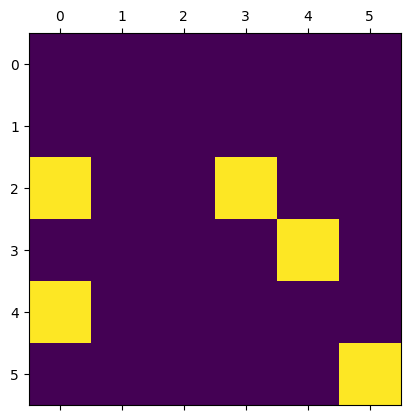

In [ ]:
mat = np.zeros((6, 6))
i = np.unravel_index([12, 15, 22, 24, 35], [6, 6])
mat[i] = 1
plt.matshow(mat)

In [ ]:
from scipy.optimize import minimize


def acc_loss_fn_min(x, y, ind, variables, pool, OPERATIONS):

    def min_func(x0):
        
        pool_ = {f'p{i}': x0[i] for i in range(len(x0))}
        y_pred = evaluate_composition(ind, variables, pool_, OPERATIONS) > 0
        result = np.equal(y, y_pred).mean()
        return result

    x_opt = minimize(min_func, list(pool.values()))
    loss = min_func(x_opt.x)
    compl = composition_node_num(ind)
    return -loss + compl * 1e-10, loss, compl

In [ ]:
best, trees = run_deap_gp(acc_loss_fn_min,
                          2,
                          36,
                          16,
                          X_all,
                          Y_all,
                          generations=10000,
                          raise_error=True,
                          log_perf_every=100,
                          log_models_every=-1,
                          mutate_params=False
                          
                          )
print("Best expression:", best)


[Gen 0] Best errors: (-0.4999999857, 0.5, 143.0)
[Gen 100] Best errors: (-0.5899999949, 0.59, 51.0)
[Gen 200] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 300] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 400] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 500] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 600] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 700] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 800] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 900] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 1000] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 1100] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 1200] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 1300] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 1400] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 1500] Best errors: (-0.6099999956, 0.61, 44.00000000000001

KeyboardInterrupt: 